# Final Data Analysis

In this notebook, we will walk through out data exploration and analysis. We have conducted more in-depth overview of the data throughout the rest of our notebooks. The purpose of this notebook is to summarize the data and our findings.

In [1]:
import pandas as pd 
import geopandas as gpd
import geopy
from shapely.geometry import Point
import folium  
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns
from pointpats import centrography
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans


# autocorrelation
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps


import spreg
from pysal.lib import weights
from pysal.explore import esda
from scipy import stats
import statsmodels.formula.api as sm
import pandas
import geopandas
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
from sklearn.cluster import KMeans, AgglomerativeClustering

import cenpy
from cenpy import products
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_absolute_error

from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


# Part One: Introduction to the Data

The aim of our project was to better understanding potential housing needs after the end of the moratorium. Due to data limitations, we focus on analyzing Pre-foreclosure notices and Ellis act evictions. Pre-foreclosure notices are seemingly straightforward measures of owner housing vulnerability. In contrast, Ellis Eviction doesn't directly address renter housing vulnerability but instead highlights in what areas landlords are more likely to turn to rent properties into condos. We will focus on understanding what type of neighborhoods are most likely to be affected by Pre-foreclosure Notices and Ellis Evictions for this set of data. 

### Where are Pre-foreclosure Notices and Ellis Evictions Happening? 

Our first graph higlights the point locations of both Pre-foreclosures Notices and Ellis Evictions.

In [2]:
preforeclosure_ellis=gpd.read_file('/Users/Nataly/Documents/GitHub/UDSSpring2020/Data/preforeclosure_ellis_pointdata.geojson')

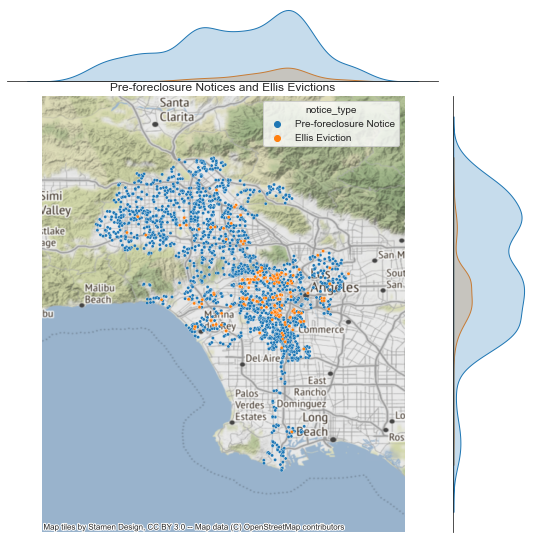

In [3]:
sns.set_style('white')
g = sns.jointplot(data = preforeclosure_ellis,
                  x='x', 
                  y='y',
                  s=10,
                  height=8,
                  hue='notice_type')

g.ax_joint.set_title('Pre-foreclosure Notices and Ellis Evictions', fontsize=12)   
# Clean axes
g.ax_joint.set_axis_off()

# add basemap
ctx.add_basemap(g.ax_joint,
                crs='epsg:4326')

According to the data, there have been a lot more Pre-Foreclosure Notices than Ellis Act Evictions. Overall, Ellis Evictions seem to be concentrated in Downtown LA, East Hollywood, Palms. Pre-foreclosures Notices are happening all across LA city.

##### Next we wanted to understand which neigobhoods had the highest number of Pre-Foreclosure Notices and Ellis Act Evictions. 

To achieve this, we first merge the point data to zip codes, as illustrated on the map below. 

Text(0.5, 1.0, 'Ellis and Pre-foreclosure Notices with Zip Codes')

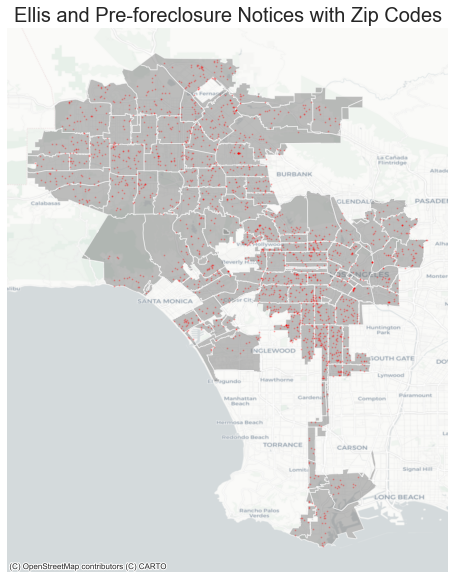

In [4]:
la_zipcodes=gpd.read_file('/Users/Nataly/Documents/GitHub/UDSSpring2020/Data/Los_Angeles_City_Zip_Codes.geojson')
# set up the plot canvas with plt.subplots
fig, ax = plt.subplots(figsize=(10, 10))

# block groups
la_zipcodes.plot(ax=ax, # this puts it in the ax plot
        color='gray', 
        edgecolor='white',
        alpha=0.5)

# arrests
preforeclosure_ellis.plot(ax=ax, # this also puts it in the same ax plot
            color='red',
            markersize=1,
            alpha=0.2)

# use the bounding box coordinates to set the x and y limits
#ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
#ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

#adding basemap
ctx.add_basemap(
    ax, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

ax.set_title('Ellis and Pre-foreclosure Notices with Zip Codes', fontsize=20)       

After counting the number of Pre-Foreclosure Notices and Ellis Act Evictions in each zip code, we calculated which neighborhoods had the highest number of each. We illustrate this in the maps below. We normalized the data by calculating the number of pre-foreclosures and ellis evictions in each neigobhood by the total number of people in each zip code.

###### Pre-Foreclosures per person


First, let's look at the overall distribution of pre-foreclosure notices per person for all of LA City. 

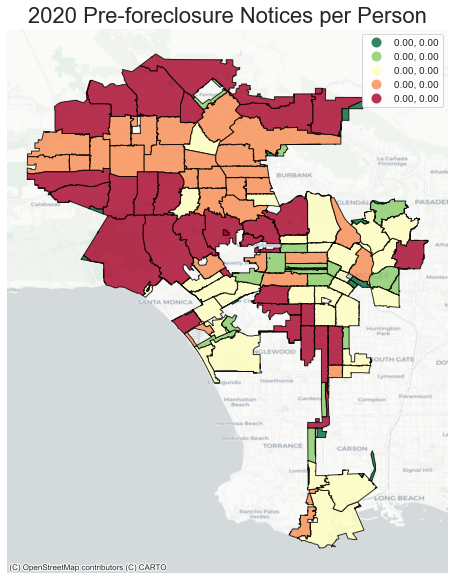

In [5]:
prefoclosure_zipcode = gpd.read_file('/Users/Nataly/Documents/GitHub/UDSSpring2020/Data/preforeclosure_ellis_acs_ovi_6.geojson')
fig,ax = plt.subplots(figsize=(10,10))

prefoclosure_zipcode.plot(ax=ax,
        column='preforeclosure_count_person',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles', edgecolor='black')

ax.axis('off')
ax.set_title('2020 Pre-foreclosure Notices per Person',fontsize=22)
ctx.add_basemap(ax, crs='epsg:4326',source=ctx.providers.CartoDB.Positron)

<AxesSubplot:xlabel='ZIPCODE'>

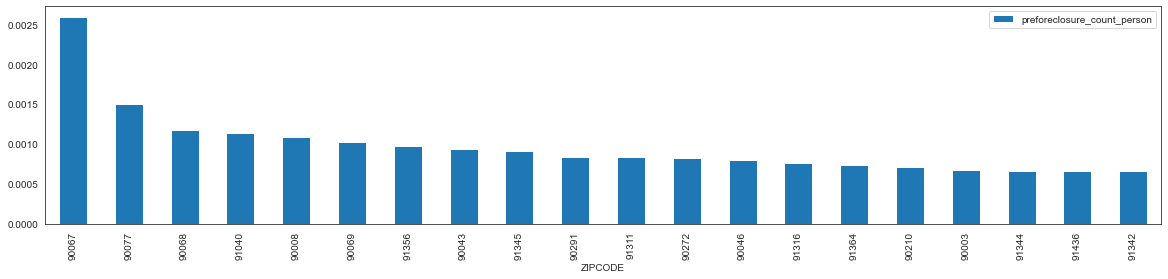

In [6]:

prefoclosure_zipcode=prefoclosure_zipcode.sort_values(by="preforeclosure_count_person", ascending=False).reset_index()
prefoclosure_zipcode[:20].plot.bar(figsize=(20,4),
                             x='ZIPCODE',
                             y='preforeclosure_count_person')

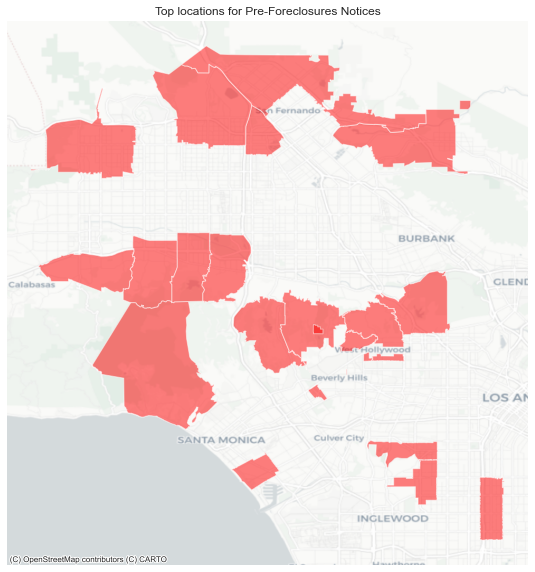

In [8]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
prefoclosure_zipcode.sort_values(by='preforeclosure_count_person',ascending=False)[:20].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top locations for Pre-Foreclosures Notices')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(
    ax, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron)


Above, we can see the neigbohoods with the top pre-foreclosure notices. These are located througout San Fernando Valley, Hollywood, and near Culvert City. The highest number of pre-foreclosures are 0.0025 per person. 

##### Ellis Evictions per person

C:\Users\Nataly\anaconda3\envs\geopandas_testenv\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Nataly\anaconda3\envs\geopandas_testenv\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


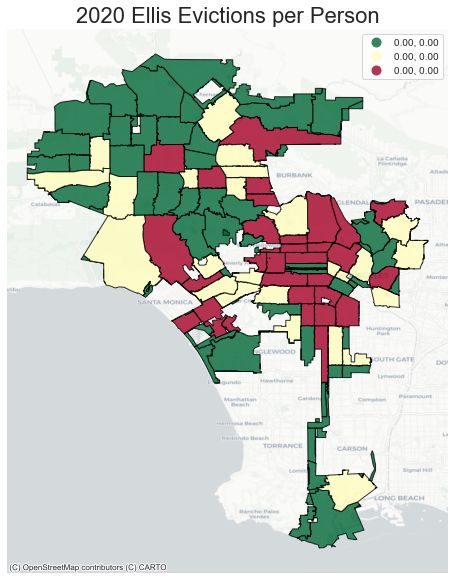

In [9]:
prefoclosure_zipcode = gpd.read_file('/Users/Nataly/Documents/GitHub/UDSSpring2020/Data/preforeclosure_ellis_acs_ovi_6.geojson')
fig,ax = plt.subplots(figsize=(10,10))

prefoclosure_zipcode.plot(ax=ax,
        column='ellis_count_person',
        legend=True,
        alpha=0.8,
        cmap='RdYlGn_r',
        scheme='quantiles', edgecolor='black')

ax.axis('off')
ax.set_title('2020 Ellis Evictions per Person',fontsize=22)
ctx.add_basemap(ax, crs='epsg:4326',source=ctx.providers.CartoDB.Positron)

<AxesSubplot:xlabel='ZIPCODE'>

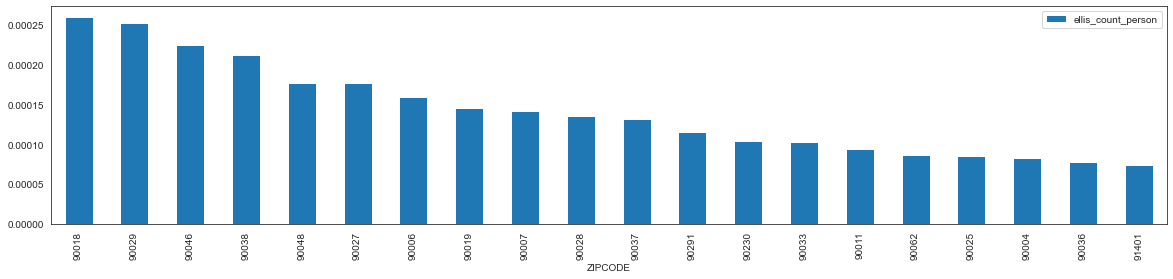

In [10]:

prefoclosure_zipcode=prefoclosure_zipcode.sort_values(by="ellis_count_person", ascending=False).reset_index()
prefoclosure_zipcode[:20].plot.bar(figsize=(20,4),
                             x='ZIPCODE',
                             y='ellis_count_person')

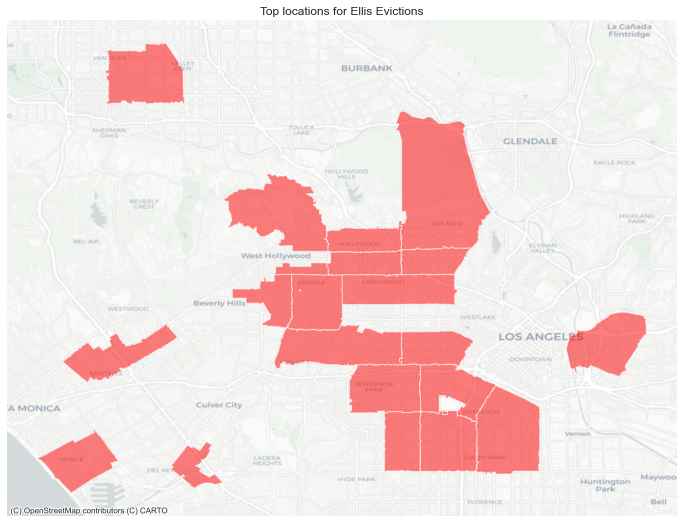

In [11]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
prefoclosure_zipcode.sort_values(by='ellis_count_person',ascending=False)[:20].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top locations for Ellis Evictions')

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(
    ax, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron)


The top locations for Ellis Evictions are concentrated near downtown Los Angeles, in Hollywood, Venice, Sawtelle, and Los Feliz. 

# Part 1.5: Normalizing the Data- Z-scores 

After our initial data exploration, we decided to normalize the data through z-scores. All the data analysis below represents variables z-score not the actual count or percentage. 

In [12]:
z_score=gpd.read_file('/Users/Nataly/Documents/GitHub/UDSSpring2020/Data/z_score_alldata.geojson')
z_score.head(2)

ZIPCODE  preforeclosure_count_per1000  ellis_count_per1000  need_person  \
0   90001                     -0.774739            -0.541367     1.169140   
1   90002                     -0.031257            -0.189010     0.770447   

   pct_Less_HS  pct_BelowPovLine  pct_white  pct_black  pct_hisp  pct_femhh  \
0     2.094602          0.404678  -1.355656   0.010635  2.026090   2.393452   
1     1.574764          0.795634  -1.352631   0.891160  1.522748   3.291122   

   pct_TenRent       OVI  preforeclosure_count_person  ellis_count_person  \
0     0.342845  1.880159                    -0.774684           -0.541361   
1     0.242309  2.395724                    -0.031340           -0.189031   

                                            geometry  
0  POLYGON ((-118.25632 33.98869, -118.25632 33.9...  
1  POLYGON ((-118.25591 33.96004, -118.25591 33.9...

# Part Two: Non-Spatial Regressions

#### Pre-foreclosures and Ellis Act Evictions

To examine the relationship between evictions and pre-foreclosure notices, we conducted a regression. This allows us to determine whether or not these two databases are correlated to each other.

In [13]:
variable_names = ['ellis_count_person']
# non-spatial multivariate regression
m1 = spreg.OLS(z_score['preforeclosure_count_person'].values, z_score[variable_names].values,
                name_y='preforeclosure_count_person', name_x=variable_names)


print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :preforeclosure_count_person                Number of Observations:         148
Mean dependent var  :      0.0000                Number of Variables   :           2
S.D. dependent var  :      1.0034                Degrees of Freedom    :         146
R-squared           :      0.0051
Adjusted R-squared  :     -0.0017
Sum squared residual:     147.243                F-statistic           :      0.7505
Sigma-square        :       1.009                Prob(F-statistic)     :      0.3877
S.E. of regression  :       1.004                Log likelihood        :    -209.623
Sigma-square ML     :       0.995                Akaike info criterion :     423.247
S.E of regression ML:      0.9974                Schwarz criterion     :     429.241

--------------------------------------------------------------

The results from our non-spatial regression reveal that number of Ellis Evictions in a neighborhood is not significantly related to the number of pre-eviction foreclosures. 

#### Pre-foreclosures and Owner Vulnerability Index

Our proposal mentioned we would be checking whether or not the Owner Vulnerability Index and the Renter Vulnerability Index were predictive of pre-foreclosure notices and evictions. As described in one of our other notebooks, we decided not to analyze the renter vulnerability index analysis due to a mismatch in the data.
 
However, we are interested in understanding the relationship between the Owner Vulnerability Index and Pre-foreclosure notices. We first explored this relationship through a non-spatial regression.

In [14]:
variable_names = ['OVI']
# non-spatial multivariate regression
m1 = spreg.OLS(z_score['preforeclosure_count_person'].values, z_score[variable_names].values,
                name_y='preforeclosure_count_person', name_x=variable_names)


print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :preforeclosure_count_person                Number of Observations:         148
Mean dependent var  :      0.0000                Number of Variables   :           2
S.D. dependent var  :      1.0034                Degrees of Freedom    :         146
R-squared           :      0.0096
Adjusted R-squared  :      0.0028
Sum squared residual:     146.575                F-statistic           :      1.4198
Sigma-square        :       1.004                Prob(F-statistic)     :      0.2354
S.E. of regression  :       1.002                Log likelihood        :    -209.287
Sigma-square ML     :       0.990                Akaike info criterion :     422.573
S.E of regression ML:      0.9952                Schwarz criterion     :     428.568

--------------------------------------------------------------

Interestingly, it doesn't the OVI is not significant correlated with pre-foreclosure notices, at least not by itself. Next, we were curious about what factors might be affecting pre-foreclosure notices so we conducted another non-spatial regression with all factors we though might be influencing pre-foreclosure notices. 

#### Which Factors Are Significantly Correlated with Pre-foreclosure Notices? 

For the model, we included all variables we though might be affecting pre-foreclosure notices.

In [15]:
variable_names = ['need_person',
 'OVI',
 'pct_white',
 'pct_Less_HS',
 'pct_femhh',
 'pct_TenRent', 'pct_BelowPovLine']
# non-spatial multivariate regression
m1 = spreg.OLS(z_score['preforeclosure_count_person'].values, z_score[variable_names].values,
                name_y='preforeclosure_count_person', name_x=variable_names)


print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :preforeclosure_count_person                Number of Observations:         148
Mean dependent var  :      0.0000                Number of Variables   :           8
S.D. dependent var  :      1.0034                Degrees of Freedom    :         140
R-squared           :      0.2556
Adjusted R-squared  :      0.2184
Sum squared residual:     110.167                F-statistic           :      6.8683
Sigma-square        :       0.787                Prob(F-statistic)     :   5.095e-07
S.E. of regression  :       0.887                Log likelihood        :    -188.157
Sigma-square ML     :       0.744                Akaike info criterion :     392.314
S.E of regression ML:      0.8628                Schwarz criterion     :     416.292

--------------------------------------------------------------

The regression displays an interesting set of results. After adding more variables into the model, the Owner Vulnerability becomes significant, with a relatively high coefficient. This indicates that after controlling for other variables, such as race, education, poverty status, the owner vulnerability is actually correlated to pre-foreclosure notices. However, this is a little hard to interpret because the owner vulnerability index is made out of similar variables as the ones included in the model, so it could potentially just be demonstrating collinearity.                                                                

The other significant variables correlated with pre-foreclosure notices include the share of female-headed households with children and the share of renters. However, this relationship is negative, indicating that the more pre-foreclosures in the neighborhood, the lower the share of female-headed households and people renting. The share of white people in a neigborhood was positively correlated with pre-forclosure notices, indicating that as the number of pre-foreclosures goes up in a neigborhood, so those the share of the white population. The combination of significant varaibles could be indicative of who can actually afford a home vs. rent, which might be driving which neigborhoods are more likely to have pre-foreclosure notices (the more owners in a neigborhoods, the higher the likelihood of a pre-foreclosure notice). 

#### Which Factors Are Significantly Correlated with Ellis Evictions? 

We were similarly intersted in understanding which factors might be correlated with Ellis Evictions, so we conduced a regression with variables we though might be affecting the number of ellis evictions in a neigborhood. 

In [16]:
variable_names = ['need_person',
 'pct_black',
 'pct_hisp',
 'pct_Less_HS',
 'pct_femhh',
 'pct_TenRent', 'pct_BelowPovLine']
# non-spatial multivariate regression
m1 = spreg.OLS(z_score['ellis_count_person'].values, z_score[variable_names].values,
                name_y='ellis_count_person', name_x=variable_names)


print(m1.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :ellis_count_person                Number of Observations:         148
Mean dependent var  :      0.0000                Number of Variables   :           8
S.D. dependent var  :      1.0034                Degrees of Freedom    :         140
R-squared           :      0.1689
Adjusted R-squared  :      0.1273
Sum squared residual:     123.007                F-statistic           :      4.0636
Sigma-square        :       0.879                Prob(F-statistic)     :   0.0004363
S.E. of regression  :       0.937                Log likelihood        :    -196.315
Sigma-square ML     :       0.831                Akaike info criterion :     408.630
S.E of regression ML:      0.9117                Schwarz criterion     :     432.608

-----------------------------------------------------------------------

Interestingly, only the share of renters in a neighborhood was significantly correlated with Ellis evictions. This indicates that the more renters that live in a neighborhood, the higher the number of Ellis Evictions.  

###### Overall, the regressions seems to indicate that pre-foreclosure notices are happening in neigbohoods with high number of owners, and that Ellis Evictions are happening in places with high number of renters. 

# Part 3: Spatial Analysis and Machine Learning 

We were interested in the spatial relationships of the variables. We first want to understand whether Pre-Foreclosure Notices and Ellis Act Evictionsare spatially clustered or not. We then conducted random forest regressions and K-cluster to better understand spatial patterns and potentially create predictive models for Pre-Foreclosure Notices and Ellis Act Evictions. 

### Spatial Autocorrelation

##### In order to calculate Spatial Autocorrelation we are going to use actual scores and not z-scores, since part of the I-moran is calculating z-scores.

In [17]:
#calculating the weight
w =  lps.weights.KNN.from_dataframe(prefoclosure_zipcode,k=4)
w.transform = 'r'

In [18]:

#Zipcode_preforeclosure_ellis_acs['ellis_count_per1000_lag'] = lps.weights.lag_spatial(w, Zipcode_preforeclosure_ellis_acs['ellis_count_per1000'])


##### Pre-Foreclosure Notices

In [19]:
prefoclosure_zipcode['preforeclosure_count_person_lag'] = lps.weights.lag_spatial(w, prefoclosure_zipcode['preforeclosure_count_person'])
y_pre_lag =  prefoclosure_zipcode['preforeclosure_count_person_lag']
moran = Moran(y_pre_lag , w)
print(moran.I)
print(moran.p_sim)

0.4585331223985434
0.001


The moran I value is about 0.46 with significant p-value. This indicates that there is spatial autocorrelation within the pre-foreclosure data. 

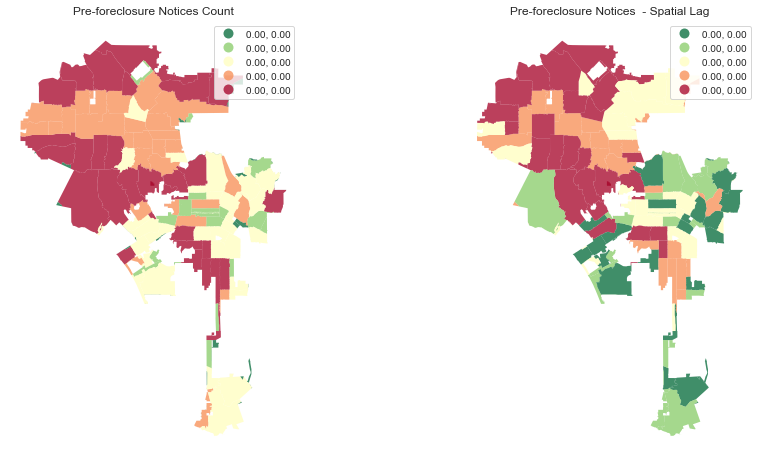

In [20]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
prefoclosure_zipcode.plot(ax=ax[0], # this assigns the map to the left subplot
         column='preforeclosure_count_person', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
          legend=True )


ax[0].axis("off")
ax[0].set_title("Pre-foreclosure Notices Count")

# spatial lag map on the right
prefoclosure_zipcode.plot(ax=ax[1], # this assigns the map to the right subplot
         column='preforeclosure_count_person_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75,
          legend=True )

ax[1].axis("off")
ax[1].set_title("Pre-foreclosure Notices  - Spatial Lag")

plt.show()

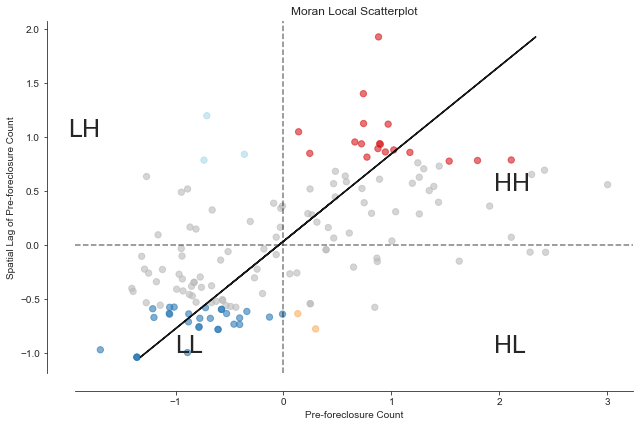

In [21]:
lisa = esda.moran.Moran_Local(y_pre_lag , w)
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)

ax.set_xlabel("Pre-foreclosure Count")
ax.set_ylabel('Spatial Lag of Pre-foreclosure Count')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

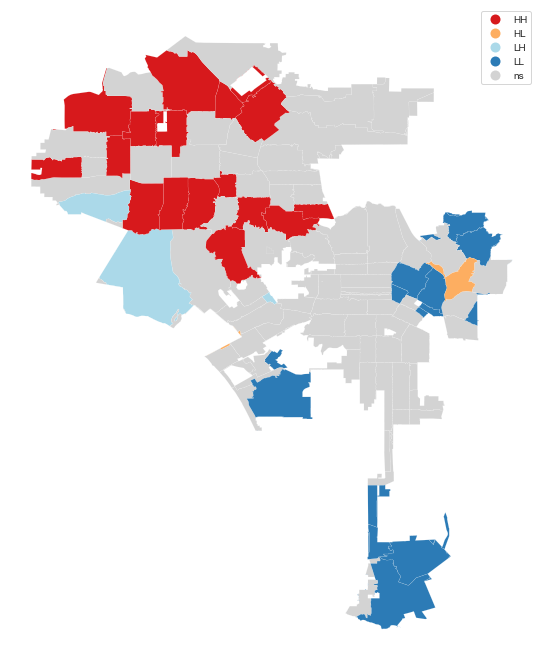

In [22]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, prefoclosure_zipcode, p=0.05, ax=ax)
plt.show()

In the pre-foreclosure data, we find that there are several clusters. There are multiple clusters of high pre-foreclosure notices in the Valley/North West portion of the city. There are also a few clusters of areas with low pre-foreclosure notices. These are primarily in the southern most of the city and some areas of downtown. 

##### Ellis Act Evictions 

In [23]:
prefoclosure_zipcode['ellis_count_person_lag'] = lps.weights.lag_spatial(w, prefoclosure_zipcode['ellis_count_person'])
y_ellis_lag =  prefoclosure_zipcode['ellis_count_person_lag']
moran = Moran(y_ellis_lag , w)
print(moran.I)
print(moran.p_sim)

0.6544799326016796
0.001


Again, the moran I is positive with a significant p-value, indicating that the data ellis evictions data is spatially autocorrelated. Now, we will conduct a few more analysis to examine what this actually means spatially (find where there are autocorrelated clusters).

C:\Users\Nataly\anaconda3\envs\geopandas_testenv\lib\site-packages\mapclassify\classifiers.py:234: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
C:\Users\Nataly\anaconda3\envs\geopandas_testenv\lib\site-packages\mapclassify\classifiers.py:237: UserWarning: Warning: setting k to 3
  Warn("Warning: setting k to %d" % k_q, UserWarning)


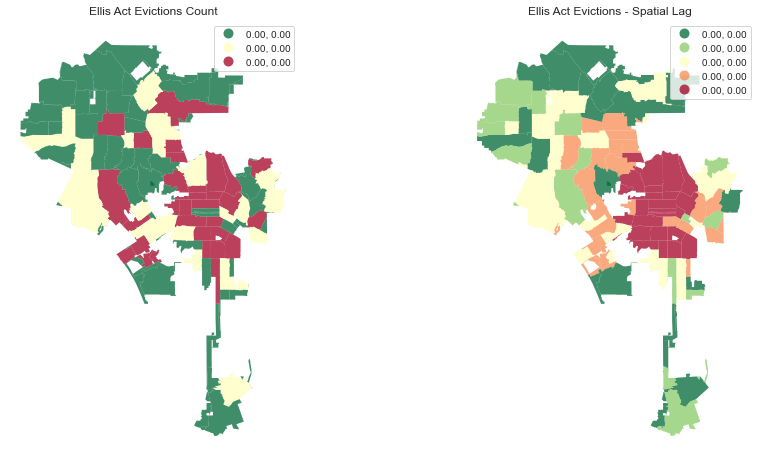

In [24]:
# create the 1x2 subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 8))

# two subplots produces ax[0] (left) and ax[1] (right)

# regular count map on the left
prefoclosure_zipcode.plot(ax=ax[0], # this assigns the map to the left subplot
         column='ellis_count_person', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75, 
          legend=True )


ax[0].axis("off")
ax[0].set_title("Ellis Act Evictions Count")

# spatial lag map on the right
prefoclosure_zipcode.plot(ax=ax[1], # this assigns the map to the right subplot
         column='ellis_count_person_lag', 
         cmap='RdYlGn_r', 
         scheme='quantiles',
         k=5, 
         edgecolor='white', 
         linewidth=0, 
         alpha=0.75,
          legend=True )

ax[1].axis("off")
ax[1].set_title("Ellis Act Evictions - Spatial Lag")

plt.show()

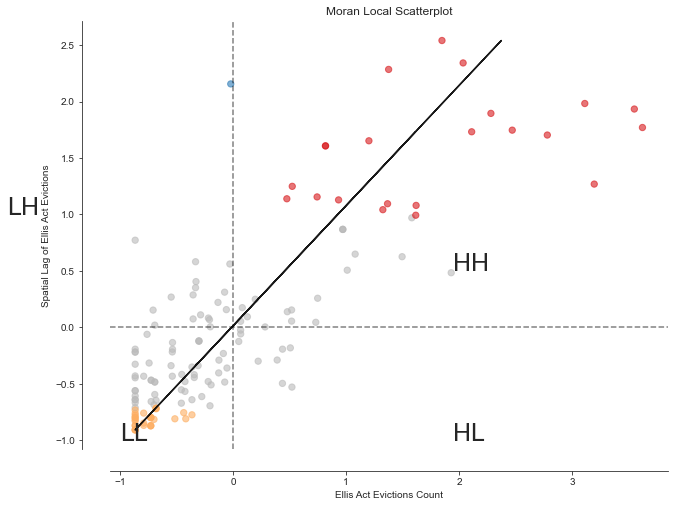

In [25]:
lisa = esda.moran.Moran_Local(y_ellis_lag  , w)
# Plot
fig,ax = plt.subplots(figsize=(10,15))

moran_scatterplot(lisa, ax=ax, p=0.05)

ax.set_xlabel("Ellis Act Evictions Count")
ax.set_ylabel('Spatial Lag of Ellis Act Evictions')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

There seems to be only clusters in HH category and LL category, not so many mistmatched (HL/LH).

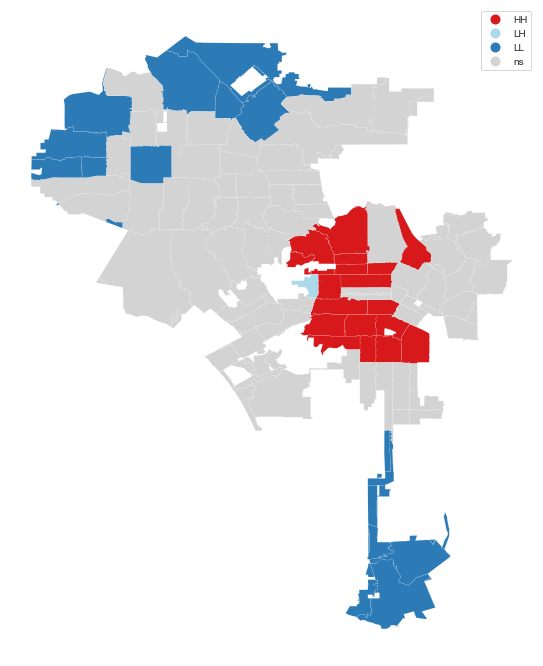

In [26]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, prefoclosure_zipcode, p=0.05, ax=ax)
plt.show()

The Ellis Evictions local autocorrelation results aren't shocking, seems like places with a high number of evictions surrounded by other places with a high number of evictions are located in downtown areas of Los Angeles, as well as parts of Hollywood. Most of the places with low evictions surrounded by other places with low evictions are in the valley. Not too much spatial mismatch (very few low/high or low/low places).

### Random Forest 

##### We are again returning to z-score data. Also, we conducted a couple random forest models for both Pre-Foreclosure Notices and Ellis Evictions. For this notebook, we are only going to include the model with the smallest mean absolute error for each.

##### Pre-Foreclosure Notices

In [27]:
xvars2 = [
    'need_person',
    'pct_Less_HS',
    'pct_white',
    'pct_black',
    'pct_hisp',
    'pct_femhh',
    'pct_TenRent','pct_BelowPovLine']
yvar2 = 'preforeclosure_count_person'

df_to_fit2 = z_score[xvars2+[yvar2]].dropna()

X_train2, X_test2, y_train2, y_test2 =  train_test_split(df_to_fit2[xvars2], df_to_fit2[yvar2], test_size = 0.25, random_state = 1)

print(len(X_train2))
print(len(X_test2))

111
37


In [28]:
rf2 = RandomForestRegressor(n_estimators = 50, random_state = 1)
# now fit the model
rf2.fit(X_train2, y_train2)
y_pred2 = rf2.predict(X_test2)

print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred2.mean(), y_test2.mean()))
print(len(y_pred2))
print(y_pred2.mean())

Predicted fraction True: 0.0650. Actual fraction True: 0.1920
37
0.06501715763419086


In [29]:
mean_abs_error2 = mean_absolute_error(y_test2, y_pred2)
print(mean_abs_error2)

0.642731677867691


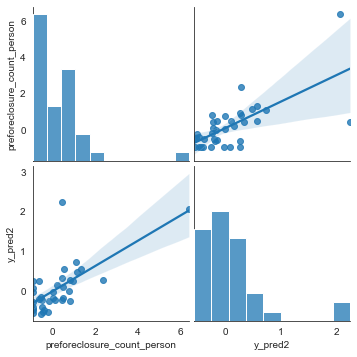

In [30]:
c2= pd.DataFrame(y_test2)
c2['y_pred2']=y_pred2
ax = sns.pairplot(c2, kind='reg')

In [31]:
importances2 = rf2.feature_importances_
forest_importances2 = pd.Series(importances2, index=X_train2.columns)

Text(0, 0.5, 'Mean decrease in impurity')

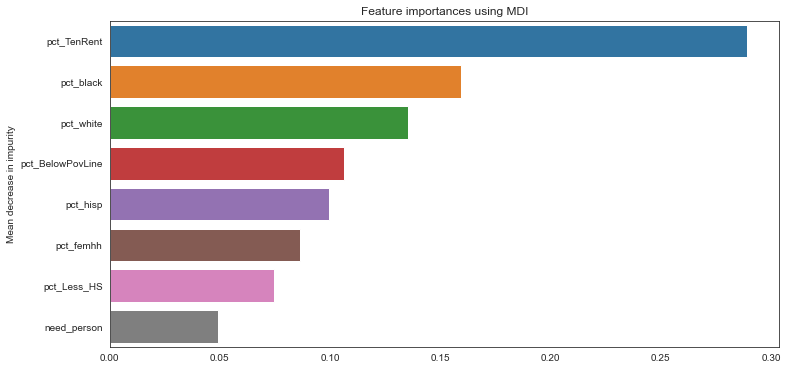

In [32]:
forest_importances2.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=forest_importances2.values, y=forest_importances2.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

The random forest model found percent renter the most helpful in predicting pre-eviction notices. Again, the percentage of owners in a neighborhood may affect whether or not there will be pre-foreclosure notices in neighborhoods. Following the share of renters, the percent of the black and white population also influences the model. 

##### Ellis Act Evictions

In [33]:
xvars3 = [
    'need_person',
    'pct_Less_HS',
    'pct_white',
    'pct_black',
    'pct_hisp',
    'pct_femhh',
    'pct_TenRent',
    'pct_BelowPovLine']
yvar3 = 'ellis_count_per1000'

df_to_fit3 = z_score[xvars3+[yvar3]].dropna()

X_train3, X_test3, y_train3, y_test3 =  train_test_split(df_to_fit3[xvars3], df_to_fit3[yvar3], test_size = 0.25, random_state = 1)

print(len(X_train3))
print(len(X_test3))

111
37


In [34]:
rf3 = RandomForestRegressor(n_estimators = 50, random_state = 1)
# now fit the model
rf3.fit(X_train3, y_train3)
y_pred3 = rf3.predict(X_test3)

print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(y_pred3.mean(), y_test3.mean()))
print(len(y_pred3))
print(y_pred3.mean())

Predicted fraction True: 0.0407. Actual fraction True: 0.2769
37
0.04067428180633229


In [35]:
mean_abs_error3 = mean_absolute_error(y_test3, y_pred3)
print(mean_abs_error3)

0.7813884127743843


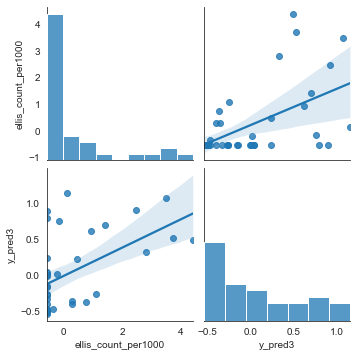

In [36]:
c3= pd.DataFrame(y_test3)
c3['y_pred3']=y_pred3
ax = sns.pairplot(c3, kind='reg')

In [37]:
importances3 = rf3.feature_importances_
forest_importances3 = pd.Series(importances3, index=X_train3.columns)

Text(0, 0.5, 'Mean decrease in impurity')

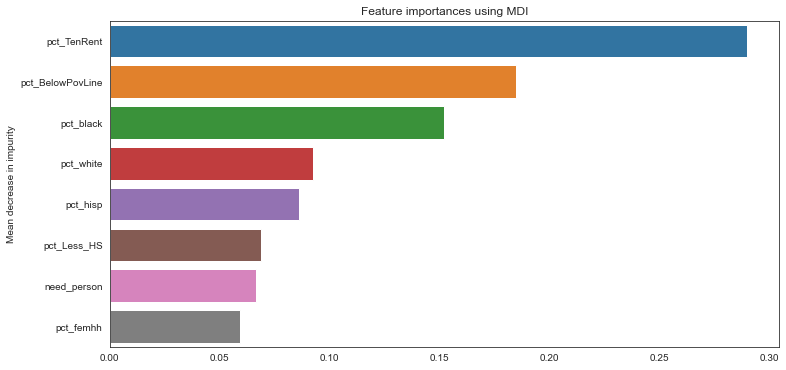

In [38]:
forest_importances3.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x=forest_importances3.values, y=forest_importances3.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

Again, we see percent renter heavily influencing the random forest model. Similar to the non-spatial regression results, it appears as if the share of owners/renters highly affects predictions of where Fre-foreclosure notices and Ellis Act evictions might happen. It would be interesting to look at the total percentage of rental units vs. owner-occupied units within each neighborhood and use that number to standardize the data. Following share of renters, percent of people living below the poverty live, and percent of black residents higly influenced the model.

### K-Clusters

####  For the K-clusters, we are again using the z-score normalize data. Additionally, on a separate notebook, we ran multiple K-cluster models. For this notebook, we are choosing the number of clusters based on findings from the previous notebook. We will also only include variables that were part of the Random Forest Model included in this notebook. 

##### Pre-Foreclosure Notices

In [39]:
z_score=z_score.set_index('ZIPCODE')

In [40]:
zscore_geometry=z_score.drop(['preforeclosure_count_person', 'ellis_count_person','preforeclosure_count_per1000',
'pct_black', 'OVI','pct_white', 'pct_hisp', 'pct_Less_HS', 'pct_femhh', 'pct_TenRent','need_person', 'ellis_count_per1000','pct_BelowPovLine'], axis=1)
zscore_geometry.head(1)

geometry
ZIPCODE                                                   
90001    POLYGON ((-118.25632 33.98869, -118.25632 33.9...

In [41]:
preforeclosure_cluster= ['preforeclosure_count_person',
 'pct_black', 'pct_white', 'pct_hisp', 'pct_Less_HS', 'pct_femhh', 'pct_TenRent','need_person']
preforeclosure_1=z_score[preforeclosure_cluster]
preforeclosure_1= preforeclosure_1.dropna()
preforeclosure_1.head()

preforeclosure_count_person  pct_black  pct_white  pct_hisp  \
ZIPCODE                                                                
90001                      -0.774684   0.010635  -1.355656  2.026090   
90002                      -0.031340   0.891160  -1.352631  1.522748   
90003                       0.986748   0.976735  -1.350050  1.505656   
90004                       0.141681  -0.363081  -0.762773  0.536904   
90005                      -0.634855  -0.256972  -1.045142  0.396771   

         pct_Less_HS  pct_femhh  pct_TenRent  need_person  
ZIPCODE                                                    
90001       2.094602   2.393452     0.342845     1.169140  
90002       1.574764   3.291122     0.242309     0.770447  
90003       1.728932   3.132915     0.625711     1.169140  
90004       0.694390  -0.147230     1.334525    -0.126612  
90005       0.903877  -0.080128     1.615510     0.272081

In [42]:

def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles 
    
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

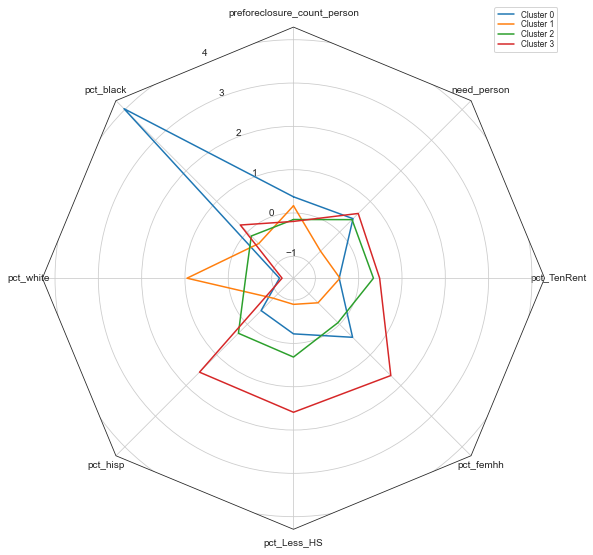

In [43]:
%matplotlib inline
kmeans = KMeans(n_clusters=4, random_state=1).fit(preforeclosure_1)
# let's put this in a function so we can call it easily again
def radar_plot(kmeans, preforeclosure_1):
    N  = kmeans.cluster_centers_.shape[1]  # number of columns / variables
    k = kmeans.n_clusters
    theta = radar_factory(N, frame='polygon')
    data = kmeans.cluster_centers_.T
    spoke_labels = [col for col in preforeclosure_1.columns if col!='cluster_id']
    fig, ax = plt.subplots(figsize=(9, 9),
                                subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


    #ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    #        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
    #                     horizontalalignment='center', verticalalignment='center')
    #        for d, color in zip(case_data, colors):
    ax.plot(theta, data) #, color=color)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ['Cluster {}'.format(kk) for kk in range(k)]
    ax.legend(labels, loc=(0.9, .95),
                                labelspacing=0.1, fontsize='small')

radar_plot(kmeans, preforeclosure_1)


cluster_id
0     6
1    64
2    51
3    27
dtype: int64


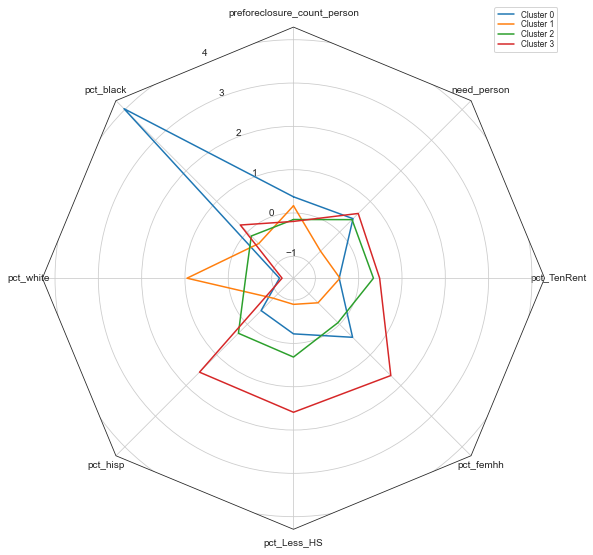

In [44]:
#preforeclosure_1.drop(columns=['cluster_id'], inplace=True)   # we don't want to include the old cluster id in our new estimates
kmeans = KMeans(n_clusters=4, random_state=1).fit(preforeclosure_1)
preforeclosure_1['cluster_id'] = kmeans.labels_
print(preforeclosure_1.groupby('cluster_id').size())
radar_plot(kmeans, preforeclosure_1)

In [45]:
preforeclosure_1 = zscore_geometry.join(preforeclosure_1)

[]

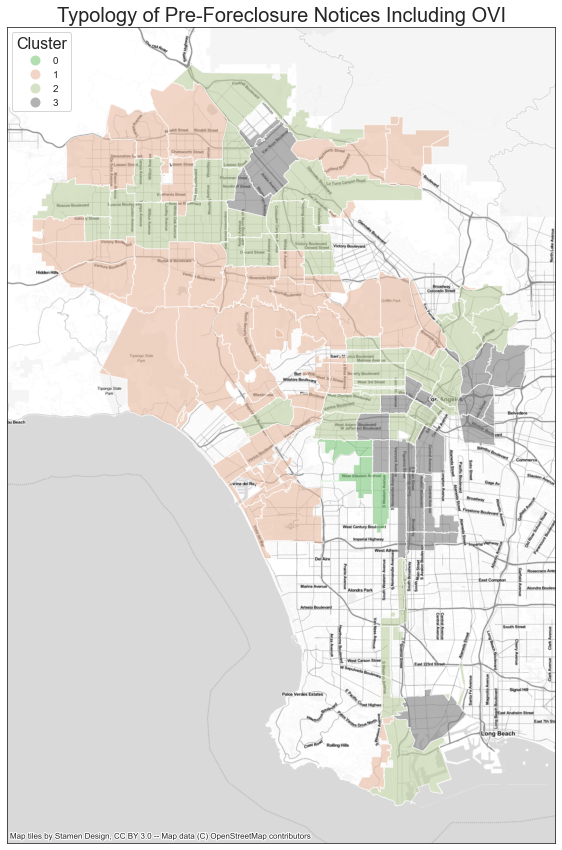

In [46]:

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#7fc97f'), (0.2, '#beaed4'), (0.4, '#fdc086'), 
               (0.6, '#ffff99'), (0.8, '#386cb0'), (1.0, '0.5')])

fig, ax = plt.subplots(figsize=(15,15))
preforeclosure_1.to_crs('EPSG:3857').plot('cluster_id', cmap=cmap, categorical=True, legend=True, ax=ax, alpha=0.6,
                                                                     legend_kwds={'loc': 'upper left'})


# all this is the same as before
legend = ax.get_legend()
legend.set_title("Cluster", prop={'size':16} )

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Typology of Pre-Foreclosure Notices Including OVI', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])

In [60]:
k5means = preforeclosure_1.groupby('cluster_id')[preforeclosure_cluster].mean()
k5means.T.round(3)

cluster_id                       0      1      2      3
preforeclosure_count_person  0.374  0.167 -0.151 -0.194
pct_black                    4.028 -0.373 -0.128  0.231
pct_white                   -1.182  0.953 -0.399 -1.242
pct_hisp                    -0.448 -0.851  0.293  1.563
pct_Less_HS                 -0.220 -0.901  0.315  1.590
pct_femhh                    0.424 -0.703 -0.053  1.672
pct_TenRent                 -0.451 -0.433  0.341  0.484
need_person                  0.438 -0.622  0.407  0.608

The data reveals two types of the cluster with a high number of pre-foreclosure notices. The first, cluster 0, makes up only a small set of neighborhoods, but it's characterized by a high share of black individuals, a low share of whites and Hispanics and renters, a high share of female-headed households, and a high level of social service need. These neigborhoods near the center of the city. The second cluster with a high number of pre-foreclosures is the biggest of the groups, and it's characterized by a high share of the white population and across all other variables (indicating a potentially high level of socioeconomic capital). These neigobhoods are located in majority north and west sides of the city.


##### Although we wanted only to discuss K-Clusters based on guidance for the Random Forest results, in this analysis, we were also interested in understanding the relationship between the owner vulnerability index and pre-foreclosure notices. Below we conducted this analysis. 

In [48]:
preforeclosure_cluster_2= ['preforeclosure_count_person', 'OVI',
 'pct_black', 'pct_white', 'pct_hisp', 'pct_Less_HS', 'pct_femhh', 'pct_TenRent','need_person']
preforeclosure_2=z_score[preforeclosure_cluster_2]
preforeclosure_2= preforeclosure_2.dropna()

cluster_id
0    67
1    49
2     6
3    26
dtype: int64


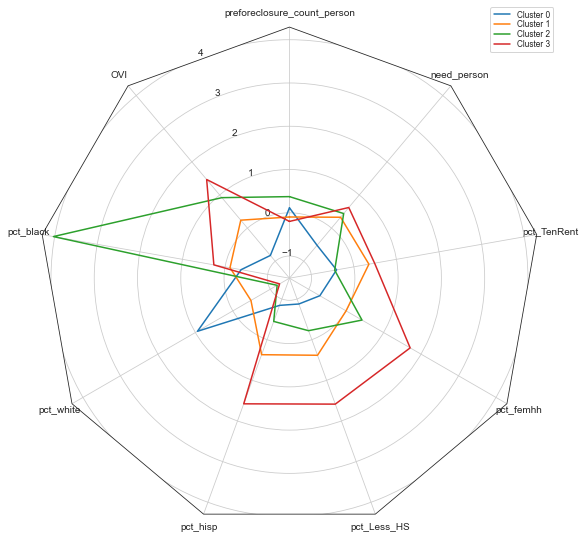

In [49]:
#preforeclosure_1.drop(columns=['cluster_id'], inplace=True)   # we don't want to include the old cluster id in our new estimates
kmeans = KMeans(n_clusters=4, random_state=1).fit(preforeclosure_2)
preforeclosure_2['cluster_id'] = kmeans.labels_
print(preforeclosure_2.groupby('cluster_id').size())
radar_plot(kmeans, preforeclosure_2)

In [50]:
preforeclosure_2 = zscore_geometry.join(preforeclosure_2)

[]

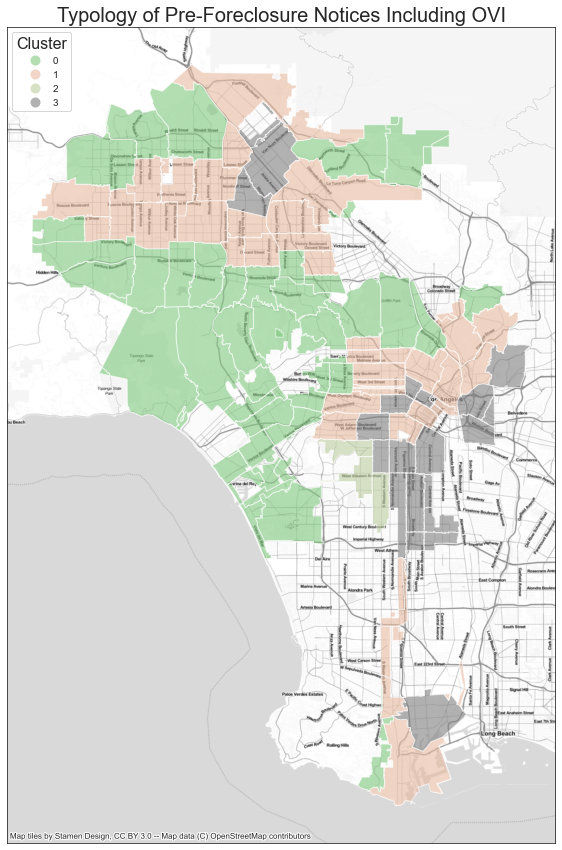

In [51]:

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#7fc97f'), (0.2, '#beaed4'), (0.4, '#fdc086'), 
               (0.6, '#ffff99'), (0.8, '#386cb0'), (1.0, '0.5')])

fig, ax = plt.subplots(figsize=(15,15))
preforeclosure_2.to_crs('EPSG:3857').plot('cluster_id', cmap=cmap, categorical=True, legend=True, ax=ax, alpha=0.6,
                                                                     legend_kwds={'loc': 'upper left'})


# all this is the same as before
legend = ax.get_legend()
legend.set_title("Cluster", prop={'size':16} )

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Typology of Pre-Foreclosure Notices Including OVI', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])

In [61]:
k5means = preforeclosure_2.groupby('cluster_id')[preforeclosure_cluster_2].mean()
k5means.T.round(3)

cluster_id                       0      1      2      3
preforeclosure_count_person  0.115 -0.097  0.374 -0.200
OVI                         -0.826  0.239  0.918  1.466
pct_black                   -0.378 -0.116  4.028  0.263
pct_white                    0.944 -0.484 -1.182 -1.248
pct_hisp                    -0.843  0.370 -0.448  1.579
pct_Less_HS                 -0.877  0.384 -0.220  1.586
pct_femhh                   -0.701 -0.001  0.424  1.710
pct_TenRent                 -0.407  0.353 -0.451  0.487
need_person                 -0.519  0.327  0.438  0.621

Looking at the owner vulnerability within the k-clusters,  the OVI appears only to anticipate one of the clusters for Pre-Foreclosure Vulnerability correctly. This is cluster two, where both the mean for the Pre-foreclosure Notice and OVI are positive. This is the smallest cluster, and it's represented by a high share of black people, female-headed households, and people with social service needs. However, there is a second cluster in this model again, which anticipates Pre-foreclosure notices, which is cluster zero. This cluster is similar to cluster two from the last model, and it is represented by a high share of the white population and a low share of all other variables. This indicates that the Owner Vulnerability Index is good at understanding socioeconomic vulnerability but might not be good at necessarily predicting owner vulnerability for all types of neighborhoods.                                                                                                           

Overall, the results of both K-cluster point to two different types of neighborhoods that will potentially have housing insecurity once the moratorium ends. The first set of neighborhoods is located in predominately white neighborhoods in the North and West parts of LA, with high shares of white people and a low socioeconomic need as traditionally described through ACS data. Neighborhoods like this might be more difficult to identify by traditional models, but machine learning tools have helped us better pick up on this pattern. It is important to do further research to understand why these neighborhoods might be getting pre-foreclosure notices.                                                                                       

The second cluster is represented by neighborhoods with high shares of black residents, with few renters, but high social service needs. Traditional methods of measuring need might more easily identify this type of neighborhood. However, more work is still necessary to understand what types of policies would be most helpful in support the needs of homeowners receiving these pre-foreclosure notices. However, these type of neighborhoods should be targeted with monetary assistance to support the needs of the residents struggling to make mortgage payments. 

##### Ellis Act Evictions

In [53]:
ellis_cluster= ['ellis_count_person',  'need_person',
    'pct_Less_HS',
    'pct_white',
    'pct_black',
    'pct_hisp',
    'pct_femhh',
    'pct_TenRent',
    'pct_BelowPovLine']
ellis_1=z_score[ellis_cluster]
ellis_1= ellis_1.dropna()

cluster_id
0    68
1    49
2    31
dtype: int64


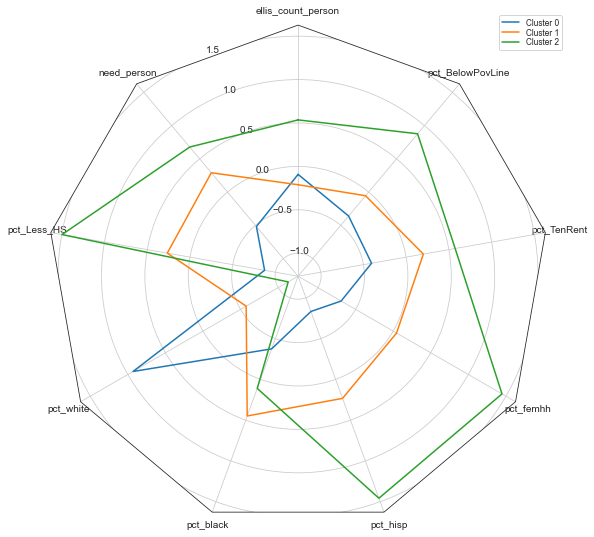

In [54]:
kmeans = KMeans(n_clusters=3).fit(ellis_1)
ellis_1['cluster_id'] = kmeans.labels_
print(ellis_1.groupby('cluster_id').size())
radar_plot(kmeans, ellis_1)

In [55]:
ellis_1 = zscore_geometry.join(ellis_1)

[]

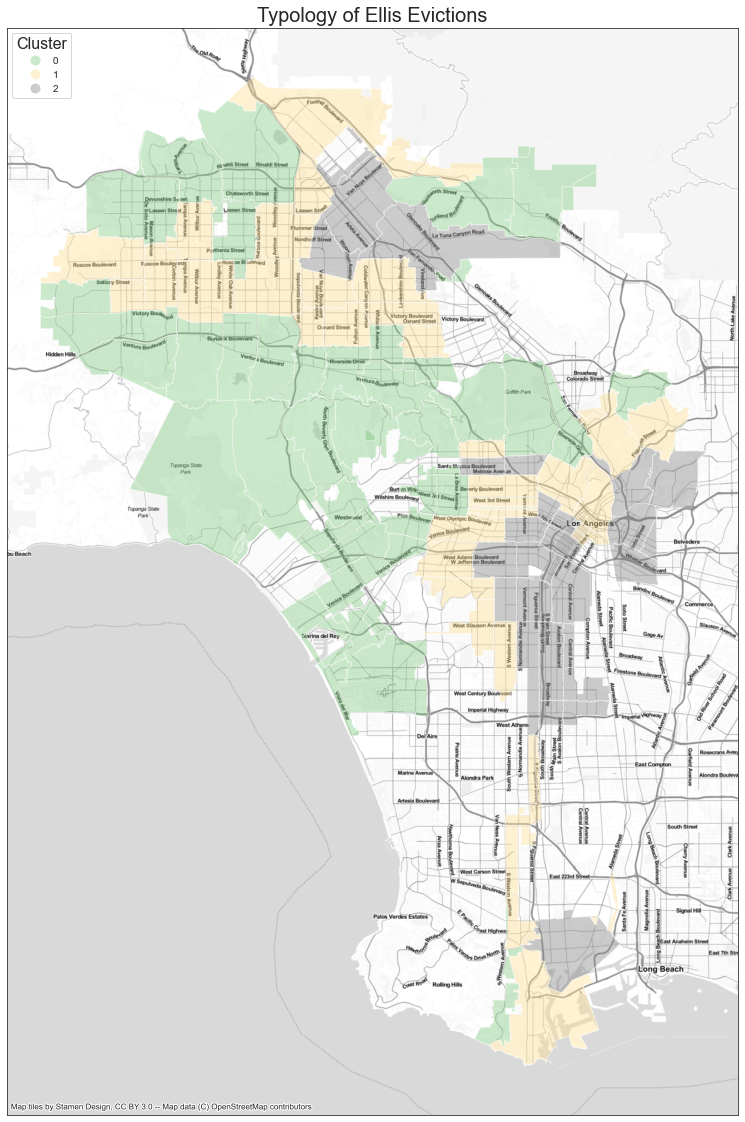

In [62]:
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, '#7fc97f'), (0.2, '#beaed4'), (0.4, '#fdc086'), 
               (0.6, '#ffff99'), (0.8, '#386cb0'), (1.0, '0.5')])

fig, ax = plt.subplots(figsize=(20,20))
ellis_1.to_crs('EPSG:3857').plot('cluster_id', cmap=cmap, categorical=True, legend=True, ax=ax, alpha=0.4,
                                                                     legend_kwds={'loc': 'upper left'})


# all this is the same as before
legend = ax.get_legend()
legend.set_title("Cluster", prop={'size':16} )

ctx.add_basemap(ax, zoom=12, source=ctx.providers.Stamen.TonerLite)
ax.set_title('Typology of Ellis Evictions', fontsize=20)                           
ax.set_xticks([])
ax.set_yticks([])

In [64]:
k5means = ellis_1.groupby('cluster_id')[ellis_cluster].mean()
k5means.T.round(3)

cluster_id              0      1      2
ellis_count_person -0.092 -0.211  0.536
need_person        -0.518  0.290  0.677
pct_Less_HS        -0.873  0.265  1.496
pct_white           0.931 -0.574 -1.133
pct_black          -0.374  0.449  0.111
pct_hisp           -0.832  0.233  1.457
pct_femhh          -0.692  0.045  1.448
pct_TenRent        -0.405  0.200  0.572
pct_BelowPovLine   -0.360 -0.055  0.877

For the k-cluster clusters for Ellis Act evictions, cluster two represents neighborhoods with high Ellis Act evictions, high social service needs, and people with less than a high school education and a high share of renters. In general, cluster two neighborhoods are located near downtown Los Angeles and parts of San Fernando Valley. Overall, it appears like these neighborhoods have a high level of people living under the poverty line. It would be important to examine the availability of affordable housing in these neighborhoods, especially considering that landlords tend to conduct Ellis act evictions to convert their rental property to condos. 

## Discussion 

We set out to understand housing insecurity for both home owners and renters. In terms of homeownership, we found two types of potential clusters of neigbohoords with housing risk once COVID-19 protections are lifted. The first group consists of predominately white neighborhoods with low socioeconomic need in the North and West parts of LA. This conflict between the apparent lack of need and the prevalence of pre-foreclosure notices should be further researched to understand more clearly where and why housing insecurity takes place and to focus support in those areas, as the grouping of neighborhoods does not seem to warrant broad social support at the end of the moratoria. 

The second cluster identified through homeownership analysis warrants targeted monetary assistance, as these neighborhoods show high social service needs, few renters, and indicators of racial disparities. 

Ellis Act eviction analysis indicates that neighborhoods near downtown Los Angeles and parts of San Fernando Valley should be analyzed further to understand the extent to which rising housing prices are affecting displacement through the Ellis Act, and provide supports for these neighborhoods in particular, as they have high social service needs and high levels of people living under the poverty line. 
